**Project Idea: Multilingual SMS Spam Detection using Cross-Lingual Transfer Learning**

**Objective:** Developing multilingual SMS spam detection system using deep learning

and cross-lingual transfer learning techniques to improve generalization

across different languages and dialects.

# Import Libraries

In [ ]:
# Core libraries
import numpy as np
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split  
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Keras 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout 
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Sampling methods
from imblearn.over_sampling import RandomOverSampler

# NLP  
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import re
import tensorflow as tf

# Word embeddings
import fastText

# Visualizations
import matplotlib.pyplot as plt
from wordcloud import WordCloud 

# Config
import warnings
warnings.filterwarnings("ignore")

# Load dataset

In [118]:
# Load dataset (assuming CSV format for simplicity)
data = pd.read_csv("data-en-hi-de-fr.csv")

In [119]:
data.head()

,labels,text,text_hi,text_de,text_fr
0,ham,"Go until jurong point, crazy.. Available only ...","Dakag बिंदु तक जाओ, पागल. केवल Bag Non महान वि...","Gehen Sie bis jurong Punkt, verrückt.. Verfügb...","Allez jusqu'à Jurong point, fou.. Disponible s..."
1,ham,Ok lar... Joking wif u oni...,ओके लामर.... if if uue पर.,Ok Lar... joking wif u oni...,J'ai fait une blague sur le wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प...,Freier Eintritt in 2 a wkly comp zum Gewinn FA...,Entrée libre dans 2 a wkly comp pour gagner FA...
3,ham,U dun say so early hor... U c already then say...,Uden इतना जल्दी कहते हैं... तो पहले से ही यूसी...,U dun sagen so früh... U c schon dann sagen...,U dun dit si tôt hor... U c déjà dire alors...
4,ham,"Nah I don't think he goes to usf, he lives aro...","नहीं, मुझे नहीं लगता कि वह हमारे लिए चला जाता ...","Nein, ich glaube nicht, dass er zu unsf geht, ...","Non, je ne pense pas qu'il va à usf, il vit da..."


# Data preprocessing 

In [120]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocess function
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove special characters
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Lemmatization and remove stopwords
    text = " ".join([lemmatizer.lemmatize(word) for word in 
                     text.split() if word not in stopwords.words('english')])
    return text

In [138]:
data['text'] = data['text'].apply(preprocess)

In [123]:
data.head()

,labels,text,text_hi,text_de,text_fr
0,ham,go jurong point crazy available bugis n great ...,"Dakag बिंदु तक जाओ, पागल. केवल Bag Non महान वि...","Gehen Sie bis jurong Punkt, verrückt.. Verfügb...","Allez jusqu'à Jurong point, fou.. Disponible s..."
1,ham,ok lar joking wif u oni,ओके लामर.... if if uue पर.,Ok Lar... joking wif u oni...,J'ai fait une blague sur le wif u oni...
2,spam,free entry wkly comp win fa cup final tkts st ...,Fktatatat 21 मई को प्राप्त करने के लिए मुफ्त प...,Freier Eintritt in 2 a wkly comp zum Gewinn FA...,Entrée libre dans 2 a wkly comp pour gagner FA...
3,ham,u dun say early hor u c already say,Uden इतना जल्दी कहते हैं... तो पहले से ही यूसी...,U dun sagen so früh... U c schon dann sagen...,U dun dit si tôt hor... U c déjà dire alors...
4,ham,nah dont think go usf life around though,"नहीं, मुझे नहीं लगता कि वह हमारे लिए चला जाता ...","Nein, ich glaube nicht, dass er zu unsf geht, ...","Non, je ne pense pas qu'il va à usf, il vit da..."


## Visualizing preprocessed data

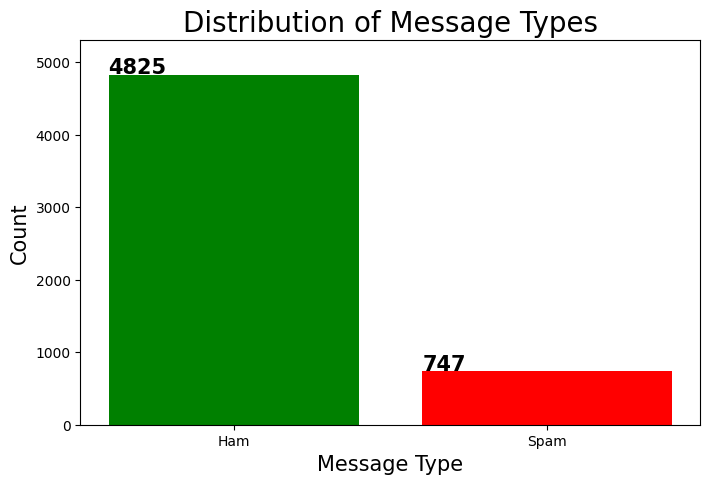

In [64]:
# Calculate counts of each label
ham_count = len(data[data['labels'] == 'ham'])
spam_count = len(data[data['labels'] == 'spam'])

# Visualization
fig, ax = plt.subplots(figsize=(8, 5))

# Bars 
ax.bar(['Ham', 'Spam'], [ham_count, spam_count], color=['green', 'red'])

# Label and scale
ax.set_ylabel('Count', size=15)
ax.set_xlabel('Message Type', size=15)
ax.set_ylim(0, max(ham_count, spam_count) * 1.1) 

# Title and annotation
ax.set_title('Distribution of Message Types', size=20)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005),
                fontsize=15, fontweight='bold')
              
plt.savefig('label_distribution.svg', bbox_inches='tight', dpi=900)

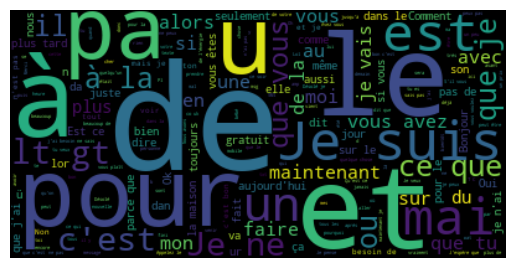

In [11]:
 # English word cloud
text = " ".join(review for review in data['text'])
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("english_wordcloud.svg", bbox_inches='tight', dpi=900)

# Hindu word cloud 
text = " ".join(review for review in data['text_hi'])
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("hindu_wordcloud.svg", bbox_inches='tight', dpi=900)

# German word cloud 
text = " ".join(review for review in data['text_de'])
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("german_wordcloud.svg", bbox_inches='tight', dpi=900)

# French word cloud
text = " ".join(review for review in data['text_fr'])  
wordcloud = WordCloud().generate(text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("french_wordcloud.svg", bbox_inches='tight', dpi=900)

# Based LSTM Model

In [77]:
# assigning data to different variables
X_en = data['text']
X_hi = data['text_hi']
X_de = data['text_de']
X_fr = data['text_fr']
y = data['labels']

# Convert class labels to numeric values
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split the data into training and testing sets
X_en_train, X_en_test,X_hi_train, X_hi_test, X_de_train, X_de_test,
X_fr_train, X_fr_test, y_train, 
y_test = train_test_split(X_en,X_hi, X_de, X_fr, y, test_size=0.2, random_state=42
)

In [78]:
# Tokenize the text data
max_words = 10000  # Maximum number of words to keep in the vocabulary
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(list(X_en_train)+ list(X_hi_train) +
                       list(X_de_train) + list(X_fr_train))

X_en_train_seq = tokenizer.texts_to_sequences(X_en_train)
X_hi_train_seq = tokenizer.texts_to_sequences(X_hi_train)
X_de_train_seq = tokenizer.texts_to_sequences(X_de_train)
X_fr_train_seq = tokenizer.texts_to_sequences(X_fr_train)

X_en_test_seq = tokenizer.texts_to_sequences(X_en_test)
X_hi_test_seq = tokenizer.texts_to_sequences(X_hi_test)
X_de_test_seq = tokenizer.texts_to_sequences(X_de_test)
X_fr_test_seq = tokenizer.texts_to_sequences(X_fr_test)

In [79]:
# Pad sequences to have the same length
max_sequence_length = 200  # Maximum length of each sequence
X_en_train_padded = pad_sequences(X_en_train_seq,
                                  maxlen=max_sequence_length, padding='post')
X_hi_train_padded = pad_sequences(X_hi_train_seq,
                                  maxlen=max_sequence_length, padding='post')
X_de_train_padded = pad_sequences(X_de_train_seq, 
                                  maxlen=max_sequence_length, padding='post')
X_fr_train_padded = pad_sequences(X_fr_train_seq,
                                  maxlen=max_sequence_length, padding='post')

X_en_test_padded = pad_sequences(X_en_test_seq, 
                                 maxlen=max_sequence_length, padding='post')
X_hi_test_padded = pad_sequences(X_hi_test_seq, 
                                 maxlen=max_sequence_length, padding='post')
X_de_test_padded = pad_sequences(X_de_test_seq, 
                                 maxlen=max_sequence_length, padding='post')
X_fr_test_padded = pad_sequences(X_fr_test_seq, 
                                 maxlen=max_sequence_length, padding='post')

In [80]:
# Build the LSTM model
embedding_dim = 100  # Dimension of the word embeddings

# English branch
input_en = Input(shape=(max_sequence_length,))
embedding_en = Embedding(input_dim=max_words, output_dim=embedding_dim, 
                         input_length=max_sequence_length)(input_en)
lstm_en = LSTM(128)(embedding_en)

# Hindu branch
input_hi = Input(shape=(max_sequence_length,))
embedding_hi = Embedding(input_dim=max_words, output_dim=embedding_dim, 
                         input_length=max_sequence_length)(input_hi)
lstm_hi = LSTM(128)(embedding_hi)

# German branch
input_de = Input(shape=(max_sequence_length,))
embedding_de = Embedding(input_dim=max_words, output_dim=embedding_dim,
                         input_length=max_sequence_length)(input_de)
lstm_de = LSTM(128)(embedding_de)

# French branch
input_fr = Input(shape=(max_sequence_length,))
embedding_fr = Embedding(input_dim=max_words, output_dim=embedding_dim, 
                         input_length=max_sequence_length)(input_fr)
lstm_fr = LSTM(128)(embedding_fr)

In [81]:
# Merge branches
merged = concatenate([lstm_en, lstm_hi, lstm_de, lstm_fr], axis=-1)

# Output layer
output = Dense(len(label_encoder.classes_), activation='softmax')(merged)

# Create the model
model = Model(inputs=[input_en, input_hi, input_de, input_fr], outputs=output)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

# Train the model
epochs = 5
batch_size = 64
model.fit(
    [X_en_train_padded, X_hi_train_padded, X_de_train_padded, X_fr_train_padded],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_en_test_padded, X_hi_test_padded,
                      X_de_test_padded, X_fr_test_padded], y_test)
)


Epoch 1/5
70/70 [==============================] - 203s 3s/step - loss: 0.4096 - accuracy: 0.8658 - val_loss: 0.3936 - val_accuracy: 0.8664
Epoch 2/5
70/70 [==============================] - 133s 2s/step - loss: 0.3964 - accuracy: 0.8658 - val_loss: 0.3950 - val_accuracy: 0.8664
Epoch 3/5
70/70 [==============================] - 117s 2s/step - loss: 0.4010 - accuracy: 0.8658 - val_loss: 0.4001 - val_accuracy: 0.8664
Epoch 4/5
70/70 [==============================] - 135s 2s/step - loss: 0.3976 - accuracy: 0.8658 - val_loss: 0.3934 - val_accuracy: 0.8664
Epoch 5/5
70/70 [==============================] - 130s 2s/step - loss: 0.3952 - accuracy: 0.8658 - val_loss: 0.3940 - val_accuracy: 0.8664


In [82]:
# Evaluate the model
loss, accuracy = model.evaluate([X_en_test_padded, X_hi_test_padded,
                                 X_de_test_padded, X_fr_test_padded], y_test, verbose=0)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

# Predict class labels for the test data
y_pred = model.predict([X_en_test_padded, X_hi_test_padded,
                        X_de_test_padded, X_fr_test_padded])
y_pred_classes = y_pred.argmax(axis=-1)

# Convert numeric predictions back to class labels
y_pred_labels = label_encoder.inverse_transform(y_pred_classes)

# Print classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))


Test Loss: 0.3940
Test Accuracy: 0.8664
35/35 [==============================] - 16s 126ms/step
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      0.87      0.80      1115



In [83]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_21 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_22 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_23 (InputLayer)          [(None, 200)]        0           []                               
                                                                                                  
 input_24 (InputLayer)          [(None, 200)]        0           []                               
                                                                                            

## Model Fine-Tuning

In [61]:
# Re-compile model
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Lower learning rate 
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-10)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train for a few more epochs with new settings
epochs = 5 
model.fit(
    [X_en_train_padded, X_hi_train_padded, X_de_train_padded, X_fr_train_padded],
    y_train,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=([X_en_test_padded, X_hi_test_padded, 
                      X_de_test_padded, X_fr_test_padded], y_test)
)

print(classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_))

Epoch 1/5
70/70 [==============================] - 163s 2s/step - loss: 0.3943 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 2/5
70/70 [==============================] - 112s 2s/step - loss: 0.3943 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 3/5
70/70 [==============================] - 106s 2s/step - loss: 0.3943 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 4/5
70/70 [==============================] - 105s 2s/step - loss: 0.3943 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
Epoch 5/5
70/70 [==============================] - 99s 1s/step - loss: 0.3943 - accuracy: 0.8658 - val_loss: 0.3932 - val_accuracy: 0.8664
              precision    recall  f1-score   support

         ham       0.87      1.00      0.93       966
        spam       0.00      0.00      0.00       149

    accuracy                           0.87      1115
   macro avg       0.43      0.50      0.46      1115
weighted avg       0.75      

# Multilingual Word Embeddings using fastText

In [124]:
# Load the embeddings for each language
embeddings = {
    'en': KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec',
                                            binary=False, limit=100000),
    'hi': KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec',
                                            binary=False, limit=100000),
    'de': KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec',
                                            binary=False, limit=100000),
    'fr': KeyedVectors.load_word2vec_format('wiki-news-300d-1M.vec',
                                            binary=False, limit=100000)
}


In [125]:
def text_to_vector(text, lang):
    # Selecting the appropriate embedding based on the language
    model = embeddings[lang]

    words = text.split()
    vectors = [model[word] for word in words if word in model]
    if vectors:
        return sum(vectors) / len(vectors)
    else:
        return [0]*300  # Assuming 300 dimensional embeddings

In [126]:
data['vector_en'] = data['text'].apply(lambda x: text_to_vector(x, 'en'))
data['vector_hi'] = data['text_hi'].apply(lambda x: text_to_vector(x, 'hi'))
data['vector_de'] = data['text_de'].apply(lambda x: text_to_vector(x, 'de'))
data['vector_fr'] = data['text_fr'].apply(lambda x: text_to_vector(x, 'fr'))

### Preparing data for training 

In [127]:
# Splitting data into training and validation set
X = data[['vector_en', 'vector_hi', 'vector_de', 'vector_fr']
        ].apply(lambda x: list(x), axis=1)
y = data['labels']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


y_train = np.where(y_train == 'spam', 1, 0).astype('float32')
y_val = np.where(y_val == 'spam', 1, 0).astype('float32')

embedding_dim = 300

# Convert to a suitable shape and type for training
X_train = np.array(X_train.tolist()).reshape(-1, 4, embedding_dim)
X_val = np.array(X_val.tolist()).reshape(-1, 4, embedding_dim)
y_train = np.array(y_train)
y_val = np.array(y_val)


In [128]:
print(y_train.dtype, y_val.dtype)

float32 float32


## Training 

### Base Model

In [98]:
# As defined above
model = Sequential()
model.add(Input(shape=(4, embedding_dim)))  # Adjusted input shape for the 4 vector columns
model.add(LSTM(124, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [99]:
early_stop = EarlyStopping(monitor='val_loss', patience=3) # patience is the number of epochs with no improvement

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), 
                    epochs=40, batch_size=64 ,callbacks=[early_stop])

Epoch 1/40
70/70 [==============================] - 50s 163ms/step - loss: 0.3511 - accuracy: 0.8753 - val_loss: 0.1980 - val_accuracy: 0.9238
Epoch 2/40
70/70 [==============================] - 1s 20ms/step - loss: 0.1449 - accuracy: 0.9466 - val_loss: 0.1360 - val_accuracy: 0.9516
Epoch 3/40
70/70 [==============================] - 1s 15ms/step - loss: 0.1173 - accuracy: 0.9585 - val_loss: 0.1252 - val_accuracy: 0.9605
Epoch 4/40
70/70 [==============================] - 2s 27ms/step - loss: 0.0978 - accuracy: 0.9659 - val_loss: 0.1132 - val_accuracy: 0.9641
Epoch 5/40
70/70 [==============================] - 1s 13ms/step - loss: 0.0858 - accuracy: 0.9729 - val_loss: 0.1101 - val_accuracy: 0.9668
Epoch 6/40
70/70 [==============================] - 1s 14ms/step - loss: 0.0823 - accuracy: 0.9720 - val_loss: 0.1086 - val_accuracy: 0.9659
Epoch 7/40
70/70 [==============================] - 1s 16ms/step - loss: 0.0763 - accuracy: 0.9771 - val_loss: 0.1075 - val_accuracy: 0.9659
Epoch 8/40


In [100]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 4, 124)            210800    
                                                                 
 dropout_1 (Dropout)         (None, 4, 124)            0         
                                                                 
 lstm_32 (LSTM)              (None, 64)                48384     
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 259,249
Trainable params: 259,249
Non-trainable params: 0
_________________________________________________________________


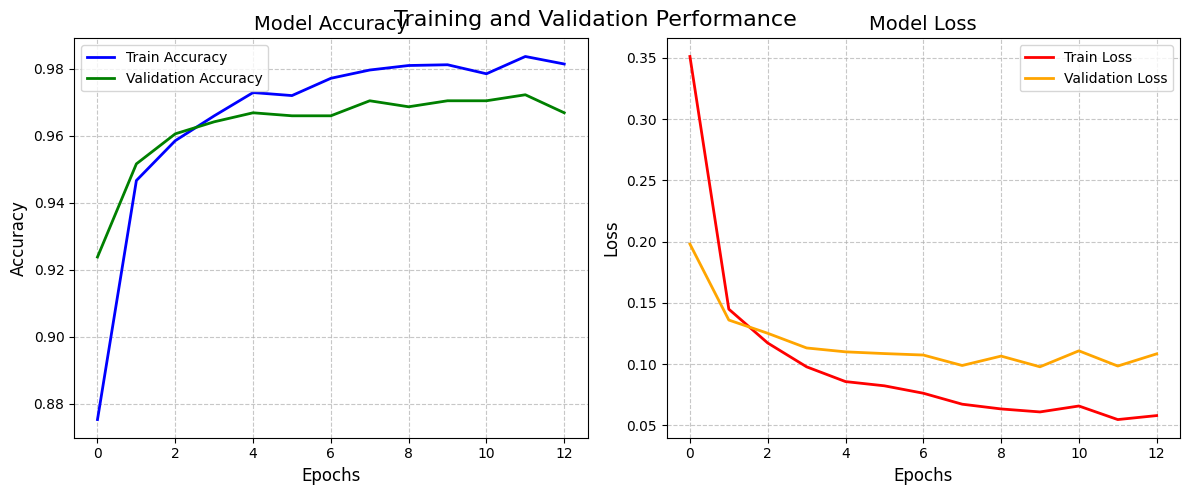

In [101]:
plt.figure(figsize=(12, 5))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy',
         color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy'
         , color='green', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# Adding a title
plt.suptitle('Training and Validation Performance', fontsize=16)

# Save the plot
plt.savefig("Model_accuracy_and_loss.png", dpi=300)
plt.show()


### Model Evaluation 

In [102]:
def evaluate_model(model, X_test, y_test):
    # Predict probabilities
    y_probs = model.predict(X_test).ravel()  # Flatten the array
    
    # Convert probabilities of the positive class to binary predictions
    y_pred = (y_probs > 0.5).astype(int)
    
    # Compute metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc_roc = roc_auc_score(y_test, y_probs)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc_roc': auc_roc
    }

###### English evaluation 

In [103]:
# Create the English dataset for evaluation
X_test_eng = data['vector_en'].apply(lambda x: np.array(x).reshape(1, -1))
X_test_eng = np.array(X_test_eng.tolist()).reshape(-1, 1, embedding_dim)
y_test_eng = np.where(data['labels'] == 'spam', 1, 0).astype('float32')

# Adjusting the English dataset for evaluation
X_test_eng_repeated = np.repeat(X_test_eng, 4, axis=1)  # Repeat the English vector 4 times to match the shape

# Evaluate on adjusted English dataset
english_metrics = evaluate_model(model, X_test_eng_repeated, y_test_eng)
print("English Dataset Evaluation:")
for metric, value in english_metrics.items():
    print(f"{metric}: {value:.4f}")

175/175 [==============================] - 4s 5ms/step
English Dataset Evaluation:
accuracy: 0.9709
precision: 0.9233
recall: 0.8541
f1: 0.8873
auc_roc: 0.9867


##### Multi-lingual evaluation 

In [104]:
# Create the Multilingual dataset for evaluation
X_test_hi = data['vector_hi'].apply(lambda x: np.array(x).reshape(1, -1))
X_test_de = data['vector_de'].apply(lambda x: np.array(x).reshape(1, -1))
X_test_fr = data['vector_fr'].apply(lambda x: np.array(x).reshape(1, -1))

X_test_multi = np.concatenate([
    np.array(X_test_hi.tolist()).reshape(-1, 1, embedding_dim),
    np.array(X_test_de.tolist()).reshape(-1, 1, embedding_dim),
    np.array(X_test_fr.tolist()).reshape(-1, 1, embedding_dim)
], axis=1)

y_test_multi = np.where(data['labels'] == 'spam', 1, 0).astype('float32')

# Adjusting the Multilingual dataset for evaluation
# Adding a dummy language with zeros to match the input shape
dummy_language = np.zeros((X_test_multi.shape[0], 1, embedding_dim))
X_test_multi_adjusted = np.concatenate([X_test_multi, dummy_language], axis=1)

# Evaluate on adjusted Multilingual dataset
multilingual_metrics = evaluate_model(model, X_test_multi_adjusted, y_test_multi)
print("\nMultilingual Dataset Evaluation:")
for metric, value in multilingual_metrics.items():
    print(f"{metric}: {value:.4f}")

175/175 [==============================] - 1s 4ms/step

Multilingual Dataset Evaluation:
accuracy: 0.9314
precision: 0.7201
recall: 0.7992
f1: 0.7576
auc_roc: 0.9565


# Bias Analysis

In [149]:
languages = {
    'English': 'vector_en',
    'Hindi': 'vector_hi',
    'German': 'vector_de',
    'French': 'vector_fr'
}

results = {}

# Iterate over each language, create test dataset, and evaluate model
for lang, vector in languages.items():
    # Create test dataset for current language
    X_test_lang = data[vector].apply(lambda x: np.array(x).reshape(1, -1))
    X_test_lang = np.array(X_test_lang.tolist()).reshape(-1, 1, embedding_dim)
    y_test_lang = np.where(data['labels'] == 'spam', 1, 0).astype('float32')

    # Adjust the dataset for evaluation
    X_test_lang_repeated = np.repeat(X_test_lang, 4, axis=1)  # Repeat the vector 4 times to match the input shape

    # Evaluate on adjusted dataset
    metrics_lang = evaluate_model(model, X_test_lang_repeated, y_test_lang)
    results[lang] = metrics_lang

# Print out the evaluation results for each language
for lang, metrics in results.items():
    print(f"\n{lang} Dataset Evaluation:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# Analysis
print("\nBias Analysis:")

# List of metrics we are considering
metrics_to_consider = ['accuracy', 'precision', 'recall', 'f1_score', 'auc_roc']

for metric in metrics_to_consider:
    # Only include results that have the metric
    values = [results[lang].get(metric, 0) for lang in languages if metric in results[lang]]
    
    if values:  # Ensure there's data for the metric
        max_lang = max(values)
        min_lang = min(values)
        diff = max_lang - min_lang
        print(f"Max difference in {metric} is {diff:.4f} between languages.")
    else:
        print(f"No data available for {metric}.")

175/175 [==============================] - 2s 7ms/step

English Dataset Evaluation:
accuracy: 0.9627
precision: 0.9354
recall: 0.7751
f1: 0.8477
auc_roc: 0.9850

Hindi Dataset Evaluation:
accuracy: 0.3896
precision: 0.1684
recall: 0.9023
f1: 0.2838
auc_roc: 0.7370

German Dataset Evaluation:
accuracy: 0.9104
precision: 0.7331
recall: 0.5221
f1: 0.6099
auc_roc: 0.9275

French Dataset Evaluation:
accuracy: 0.8659
precision: 0.5000
recall: 0.0750
f1: 0.1304
auc_roc: 0.8553

Bias Analysis:
Max difference in accuracy is 0.5730 between languages.
Max difference in precision is 0.7670 between languages.
Max difference in recall is 0.8273 between languages.
No data available for f1_score.
Max difference in auc_roc is 0.2480 between languages.


# Hyperparamter the model

In [133]:
# As defined above
model = Sequential()
model.add(Input(shape=(2, embedding_dim)))  # Adjusted input shape for the 4 vector columns
model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [130]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_37 (LSTM)              (None, 2, 256)            570368    
                                                                 
 dropout_4 (Dropout)         (None, 2, 256)            0         
                                                                 
 lstm_38 (LSTM)              (None, 64)                82176     
                                                                 
 dense_10 (Dense)            (None, 1)                 65        
                                                                 
Total params: 652,609
Trainable params: 652,609
Non-trainable params: 0
_________________________________________________________________


In [134]:
# Defining the model
model = Sequential()
model.add(LSTM(256, input_shape=(4, 300), return_sequences=True))  # Updated input shape
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dense(1, activation='sigmoid'))

# Compiling the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Defining the EarlyStopping callback
early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Training the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=40,
                    batch_size=64, callbacks=[early_stop])


Epoch 1/40
70/70 [==============================] - 18s 79ms/step - loss: 0.3001 - accuracy: 0.8919 - val_loss: 0.1485 - val_accuracy: 0.9471
Epoch 2/40
70/70 [==============================] - 2s 33ms/step - loss: 0.1249 - accuracy: 0.9538 - val_loss: 0.1282 - val_accuracy: 0.9507
Epoch 3/40
70/70 [==============================] - 2s 30ms/step - loss: 0.0978 - accuracy: 0.9666 - val_loss: 0.1309 - val_accuracy: 0.9561
Epoch 4/40
70/70 [==============================] - 2s 30ms/step - loss: 0.0883 - accuracy: 0.9675 - val_loss: 0.1085 - val_accuracy: 0.9605
Epoch 5/40
70/70 [==============================] - 2s 30ms/step - loss: 0.0767 - accuracy: 0.9742 - val_loss: 0.1032 - val_accuracy: 0.9641
Epoch 6/40
70/70 [==============================] - 2s 32ms/step - loss: 0.0681 - accuracy: 0.9773 - val_loss: 0.1402 - val_accuracy: 0.9507
Epoch 7/40
70/70 [==============================] - 2s 33ms/step - loss: 0.0648 - accuracy: 0.9800 - val_loss: 0.1329 - val_accuracy: 0.9525
Epoch 8/40
7

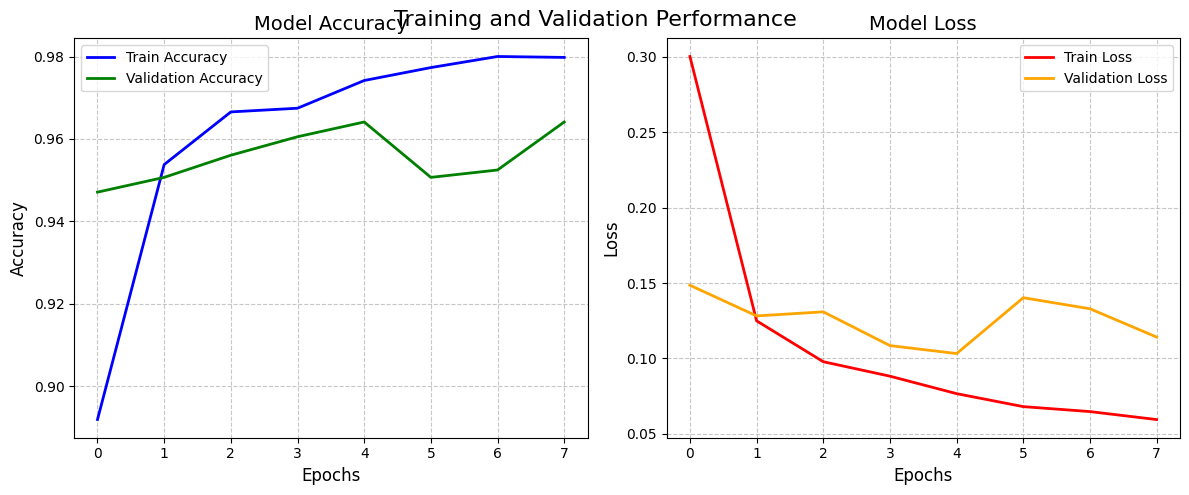

In [135]:
plt.figure(figsize=(12, 5))

# Plot for Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', color='blue', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='green', linewidth=2)
plt.title('Model Accuracy', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

# Plot for Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', color='red', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange', linewidth=2)
plt.title('Model Loss', fontsize=14)
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()

# Adding a title
plt.suptitle('Training and Validation Performance', fontsize=16)

# Save the plot
plt.savefig("Hyper Model_accuracy_and_loss.png", dpi=300)
plt.show()


In [136]:
# Create the Multilingual dataset for evaluation
X_test_hi = data['vector_hi'].apply(lambda x: np.array(x).reshape(1, -1))
X_test_de = data['vector_de'].apply(lambda x: np.array(x).reshape(1, -1))
X_test_fr = data['vector_fr'].apply(lambda x: np.array(x).reshape(1, -1))

X_test_multi = np.concatenate([
    np.array(X_test_hi.tolist()).reshape(-1, 1, embedding_dim),
    np.array(X_test_de.tolist()).reshape(-1, 1, embedding_dim),
    np.array(X_test_fr.tolist()).reshape(-1, 1, embedding_dim)
], axis=1)

y_test_multi = np.where(data['labels'] == 'spam', 1, 0).astype('float32')

# Adjusting the Multilingual dataset for evaluation
# Adding a dummy language with zeros to match the input shape
dummy_language = np.zeros((X_test_multi.shape[0], 1, embedding_dim))
X_test_multi_adjusted = np.concatenate([X_test_multi, dummy_language], axis=1)

# Evaluate on adjusted Multilingual dataset
multilingual_metrics = evaluate_model(model, X_test_multi_adjusted, y_test_multi)
print("\nMultilingual Dataset Evaluation:")
for metric, value in multilingual_metrics.items():
    print(f"{metric}: {value:.4f}")

175/175 [==============================] - 3s 8ms/step

Multilingual Dataset Evaluation:
accuracy: 0.9323
precision: 0.8246
recall: 0.6292
f1: 0.7137
auc_roc: 0.9565
